## ***STOCK TICKER***


In [266]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime as dt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam

import yfinance as yf
import mplfinance as mpf
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")
import joblib as jb
import talib as tb


In [220]:
df = yf.Ticker("AAPL")

pd.set_option('display.max_rows', None)

df_data = df.history(period="max")
df_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11060 entries, 1980-12-12 00:00:00-05:00 to 2024-10-25 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          11060 non-null  float64
 1   High          11060 non-null  float64
 2   Low           11060 non-null  float64
 3   Close         11060 non-null  float64
 4   Volume        11060 non-null  int64  
 5   Dividends     11060 non-null  float64
 6   Stock Splits  11060 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 691.2 KB


In [221]:
df_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-10-21 00:00:00-04:00,234.449997,236.850006,234.449997,236.479996,36254500,0.0,0.0
2024-10-22 00:00:00-04:00,233.889999,236.220001,232.600006,235.860001,38846600,0.0,0.0
2024-10-23 00:00:00-04:00,234.080002,235.139999,227.759995,230.759995,52287000,0.0,0.0
2024-10-24 00:00:00-04:00,229.979996,230.820007,228.410004,230.570007,31109500,0.0,0.0
2024-10-25 00:00:00-04:00,229.740005,233.220001,229.570007,231.410004,38776700,0.0,0.0


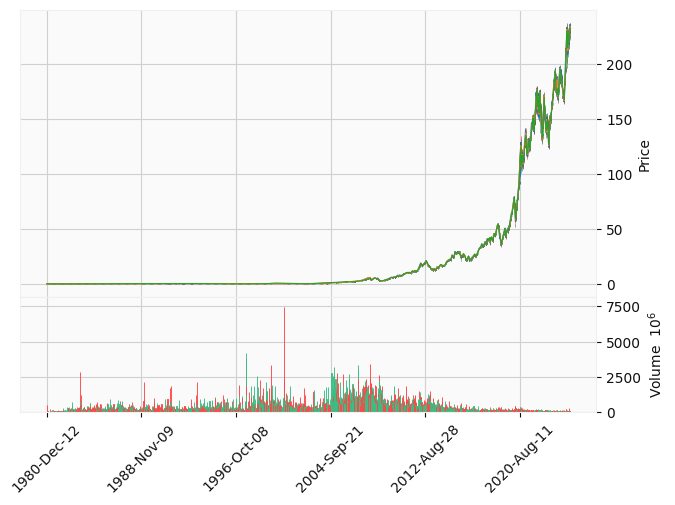

In [222]:
# draw general candle plots
mpf.plot(df_data, type = 'candle', volume =True, style = 'yahoo', mav = (3,6,9))


## **Feature engineer**

In [223]:
# Calculate additional metrics
df_data['Daily_Return'] = df_data['Close'].pct_change() * 100
df_data['Price_Change'] = df_data['Close'] - df_data['Open']
df_data['Price_Change_Pct'] = abs(((df_data['Close'] - df_data['Open']) / df_data['Open']) * 100)

df_data['RSI'] = tb.RSI(df_data['Close'], timeperiod=14)
# Calculate 20-day and 50-day SMAs for short and medium-term analysis
df_data['SMA20'] = tb.SMA(df_data['Close'], timeperiod=20)
df_data['SMA50']  = tb.SMA(df_data['Close'], timeperiod=50)
# Calculate the 200-day SMA for long-term analysis
df_data['SMA200'] = tb.SMA(df_data['Close'], timeperiod=200)
# calculate additional indicators
df_data['EMA12']  = tb.EMA(df_data['Close'], timeperiod=12)
df_data['EMA26'] = tb.EMA(df_data['Close'], timeperiod=26)
df_data['Bollinger_Upper'],df_data['Bollinger_Middle'] ,df_data['Bollinger_Lower'] = tb.BBANDS(df_data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df_data['ATR'] = tb.ATR(df_data['High'], df_data['Low'], df_data['Close'], timeperiod=14)


In [224]:
df_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,Price_Change,Price_Change_Pct,RSI,SMA20,SMA50,SMA200,EMA12,EMA26,Bollinger_Upper,Bollinger_Middle,Bollinger_Lower,ATR
Date,,,,,,,,,,,,,,,,,,,,
2024-10-21 00:00:00-04:00,234.449997,236.850006,234.449997,236.479996,36254500,0.0,0.0,0.629785,2.029999,0.865856,63.419998,229.082999,225.9344,199.802294,231.294332,228.645067,236.327450,229.082999,221.838549,4.230731
2024-10-22 00:00:00-04:00,233.889999,236.220001,232.600006,235.860001,38846600,0.0,0.0,-0.262177,1.970001,0.842277,62.123959,229.507500,226.3010,200.079119,231.996742,229.179506,237.276665,229.507500,221.738334,4.205679
2024-10-23 00:00:00-04:00,234.080002,235.139999,227.759995,230.759995,52287000,0.0,0.0,-2.162302,-3.320007,1.418322,52.601347,229.727000,226.4908,200.308626,231.806473,229.296580,237.376325,229.727000,222.077675,4.483845
2024-10-24 00:00:00-04:00,229.979996,230.820007,228.410004,230.570007,31109500,0.0,0.0,-0.082331,0.590012,0.256549,52.279856,229.879500,226.6678,200.539276,231.616248,229.390908,237.468117,229.879500,222.290882,4.335713
2024-10-25 00:00:00-04:00,229.740005,233.220001,229.570007,231.410004,38776700,0.0,0.0,0.364313,1.669998,0.726908,53.629298,230.060500,226.8016,200.768895,231.584518,229.540470,237.613735,230.060500,222.507266,4.286733


In [225]:
df_data.to_csv('stock.csv')

In [226]:
df_data.isnull().sum()

Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Dividends             0
Stock Splits          0
Daily_Return          1
Price_Change          0
Price_Change_Pct      0
RSI                  14
SMA20                19
SMA50                49
SMA200              199
EMA12                11
EMA26                25
Bollinger_Upper      19
Bollinger_Middle     19
Bollinger_Lower      19
ATR                  14
dtype: int64

In [227]:
df_data.dropna(inplace=True)


## CHECK CORRELATION

In [228]:
corr = df_data.corr()

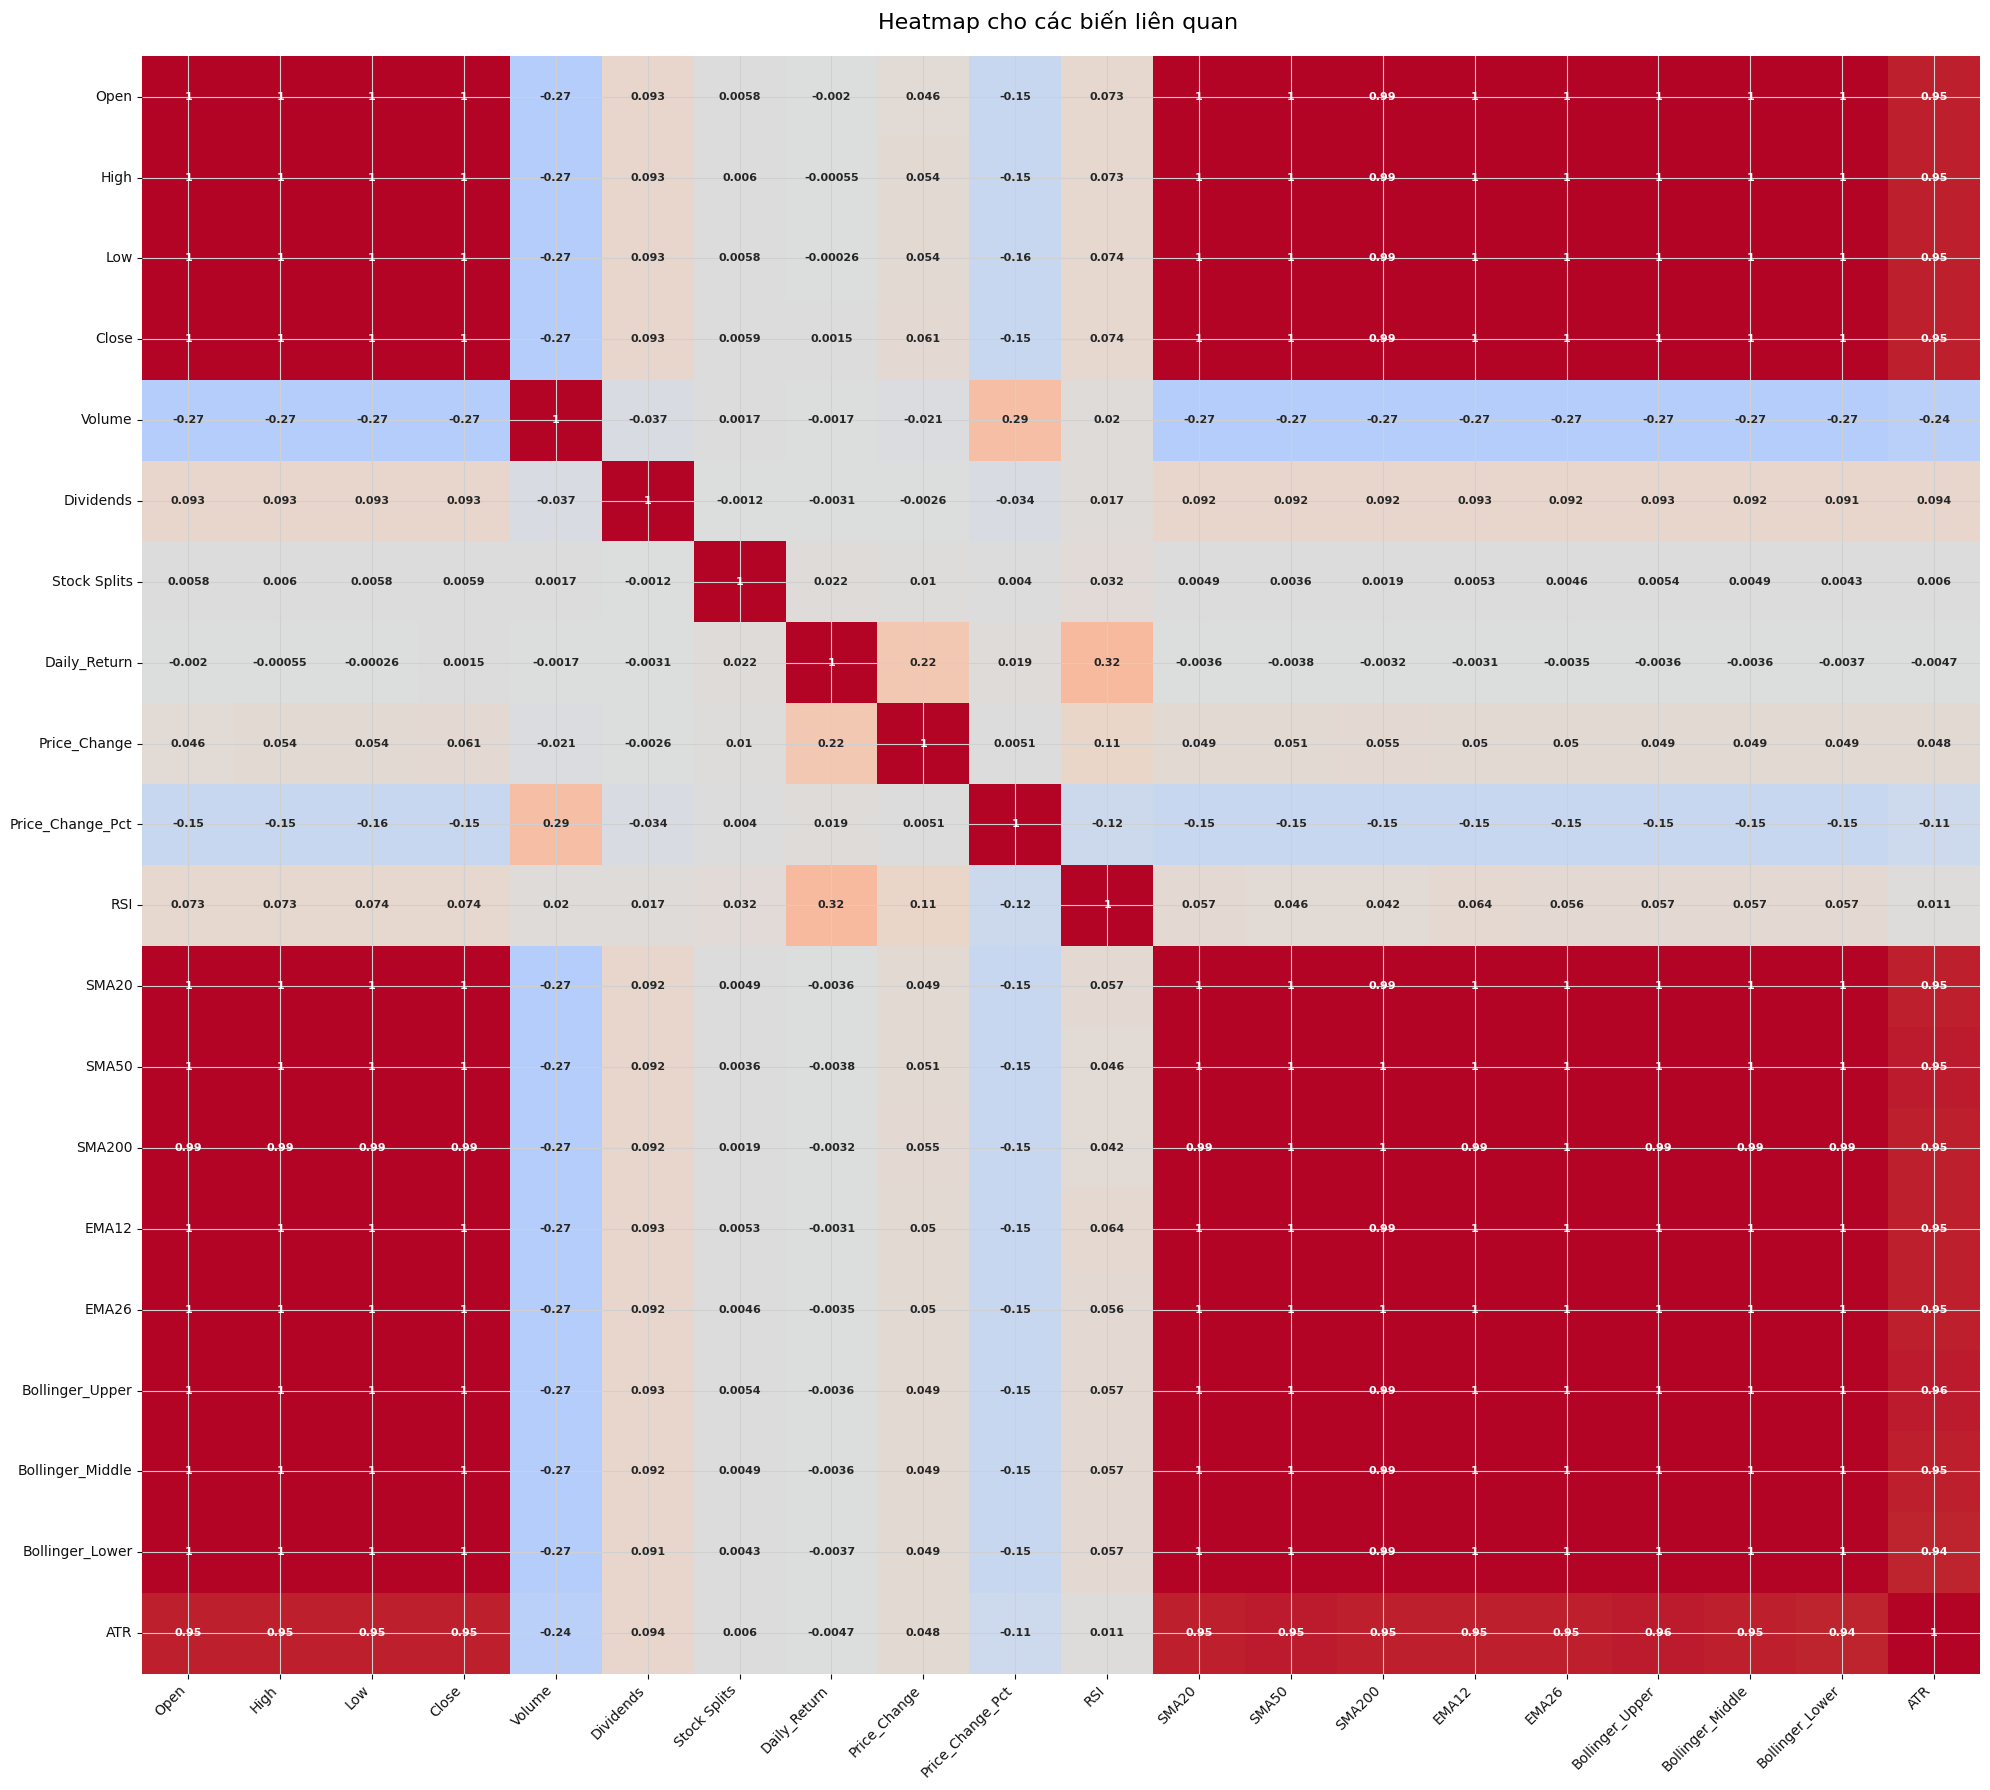

In [229]:

fig, ax = plt.subplots(figsize=(20, 18))  
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True,
            cmap='coolwarm', annot_kws={'fontsize': 8, 'fontweight': 'bold'}, cbar=False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

plt.title('Heatmap cho các biến liên quan ', fontsize=16, pad=20)
plt.tight_layout()  # Adjust the layout to fit everything
plt.show()

In [230]:
corr_close = corr['Close']
corr_close = corr_close.abs().sort_values(ascending=False)
print('Correlation :')
print(corr_close)

Correlation :
Close               1.000000
High                0.999944
Low                 0.999944
Open                0.999880
EMA12               0.999583
EMA26               0.999036
Bollinger_Middle    0.998992
SMA20               0.998992
Bollinger_Upper     0.998785
Bollinger_Lower     0.998491
SMA50               0.997397
SMA200              0.992982
ATR                 0.947240
Volume              0.271120
Price_Change_Pct    0.154776
Dividends           0.093085
RSI                 0.074411
Price_Change        0.061420
Stock Splits        0.005950
Daily_Return        0.001474
Name: Close, dtype: float64


In [231]:
# viết function để tự độngđộng hóa
def correlation(corr, threshold):
    corr_pair = [] # Set of all the names of correlated columns
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold : 
                corr_pair.append((corr.columns[i], corr.columns[j], corr.iloc[i,j]))
    return corr_pair

In [232]:
correlated_features = correlation(corr, 0.8) # các features cần bị loại bỏ

In [233]:
drop_features = []
for i ,j, k in correlated_features:
    drop_features.append(i)
drop_features = list(set(drop_features))
drop_features

['Bollinger_Middle',
 'Bollinger_Upper',
 'SMA50',
 'SMA20',
 'EMA26',
 'High',
 'Low',
 'SMA200',
 'Bollinger_Lower',
 'ATR',
 'Close',
 'EMA12']

In [234]:
df_features = df_data.drop([
 'Bollinger_Middle',
 'SMA200',
 'Low',
 'High',
], axis=1)

df_features.tail() 
# remove Bollinger_Middle (the same as SMA20),
# High and Low (not relevent for close price which is only affected by moving trend), 
# SMA200 ( too long since we only predict 30 days max)

,Open,Close,Volume,Dividends,Stock Splits,Daily_Return,Price_Change,Price_Change_Pct,RSI,SMA20,SMA50,EMA12,EMA26,Bollinger_Upper,Bollinger_Lower,ATR
Date,,,,,,,,,,,,,,,,
2024-10-21 00:00:00-04:00,234.449997,236.479996,36254500,0.0,0.0,0.629785,2.029999,0.865856,63.419998,229.082999,225.9344,231.294332,228.645067,236.327450,221.838549,4.230731
2024-10-22 00:00:00-04:00,233.889999,235.860001,38846600,0.0,0.0,-0.262177,1.970001,0.842277,62.123959,229.507500,226.3010,231.996742,229.179506,237.276665,221.738334,4.205679
2024-10-23 00:00:00-04:00,234.080002,230.759995,52287000,0.0,0.0,-2.162302,-3.320007,1.418322,52.601347,229.727000,226.4908,231.806473,229.296580,237.376325,222.077675,4.483845
2024-10-24 00:00:00-04:00,229.979996,230.570007,31109500,0.0,0.0,-0.082331,0.590012,0.256549,52.279856,229.879500,226.6678,231.616248,229.390908,237.468117,222.290882,4.335713
2024-10-25 00:00:00-04:00,229.740005,231.410004,38776700,0.0,0.0,0.364313,1.669998,0.726908,53.629298,230.060500,226.8016,231.584518,229.540470,237.613735,222.507266,4.286733


### ***BUILD MODEL***

In [235]:
X = df_features.values
y = df_features['Close']

In [236]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(y.values.reshape(-1,1)) 


In [237]:
dataset = y.values

In [238]:
training_data_len  = math.ceil(len(dataset)*.8)
training_data_len

8689

In [239]:
prediction_days = 60
future = 30
# (split data into x_train, y_train) 
x_train = []
y_train =[]

for i in range(prediction_days, len(scaled_data)-future):
    x_train.append(scaled_data[i-prediction_days:i,0])
    y_train.append(scaled_data[i+future,0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [268]:
# Set random seed
np.random.seed(42)
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(x_train, y_train, batch_size=32, epochs=10)


Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 0.0077 - mean_absolute_error: 0.0337
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - loss: 0.0011 - mean_absolute_error: 0.0133
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - loss: 0.0010 - mean_absolute_error: 0.0148
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.0010 - mean_absolute_error: 0.0146
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - loss: 9.4692e-04 - mean_absolute_error: 0.0134
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 8.6822e-04 - mean_absolute_error: 0.0139
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - loss: 8.8148e-04 - mean_absolute_error: 0.0132
Epoch 8/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - loss: 7.5866e-04 - mean_absolute_error: 0.0131
Epoch 9/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 8.5647e-04 - mean_absolute_error: 0.0136
Epoch 10/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 7.7354e-04 - mean_absolute

## Testing

In [269]:
test_data = scaled_data[training_data_len - prediction_days: , :]

In [271]:
X_test = []
y_test = scaled_data[training_data_len:,:]
for i in range(prediction_days, len(test_data)):
    X_test.append(test_data[i-prediction_days:i,0])

In [272]:
X_test = np.array(X_test)
y_test = np.array(y_test)


In [273]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [274]:
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [275]:
model.evaluate(X_test, y_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.0558e-04 - mean_absolute_error: 0.0131


[0.0008440949604846537, 0.02166411094367504]

### ***RESULT***

In [276]:
train = df_data[:training_data_len]
valid = df_data[training_data_len:]
valid['Prediction'] = predicted_price

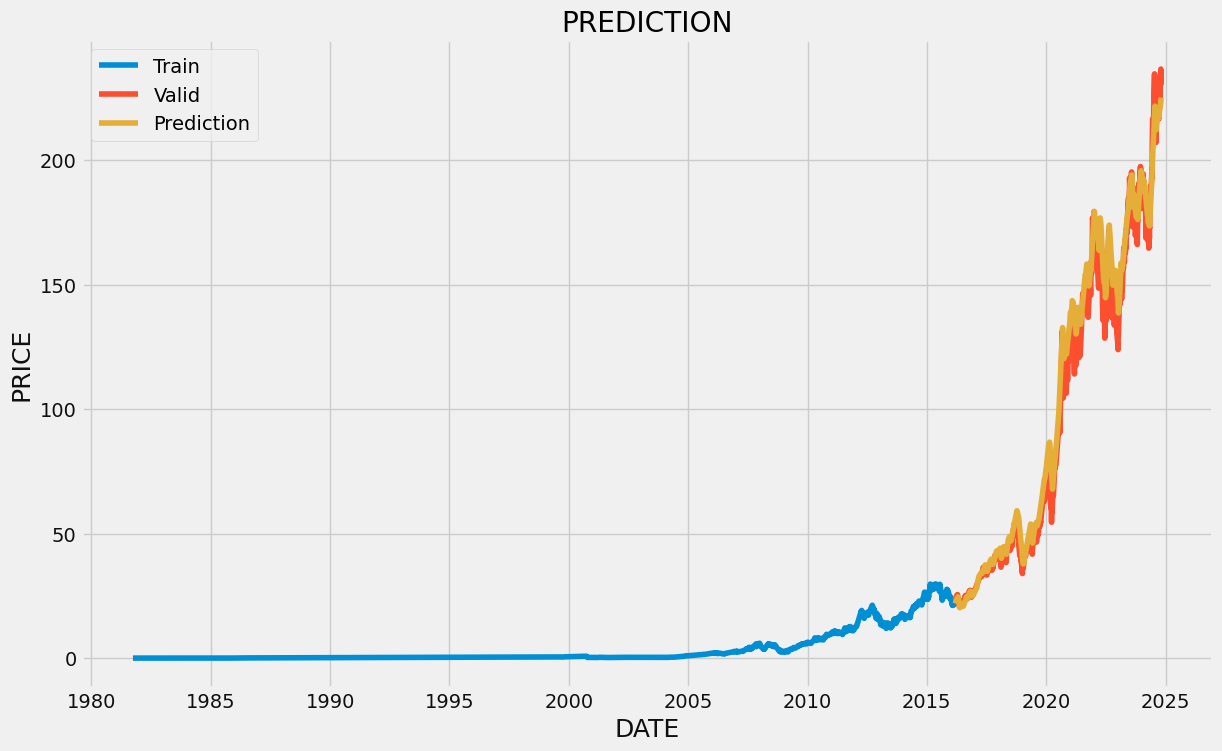

In [277]:
plt.figure(figsize = (13,8))
plt.title('PREDICTION')
plt.xlabel('DATE', fontsize  = 18)
plt.ylabel('PRICE',fontsize  = 18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Prediction'])
plt.legend(['Train', 'Valid', 'Prediction'], loc = 'upper left')
plt.show()



In [278]:
result = valid[['Close','Prediction']]
result.reset_index().tail()

,Date,Close,Prediction
2167,2024-10-21 00:00:00-04:00,236.479996,223.200195
2168,2024-10-22 00:00:00-04:00,235.860001,223.825455
2169,2024-10-23 00:00:00-04:00,230.759995,224.446365
2170,2024-10-24 00:00:00-04:00,230.570007,224.833038
2171,2024-10-25 00:00:00-04:00,231.410004,225.025055


In [279]:
# check acuracy 
def Accuracy_result(actual_price, prediction):
    result = np.mean(100 * (np.abs(actual_price - prediction) / prediction))
    return(100-result)
print("The accuracy for this model is", str(Accuracy_result(valid['Close'][2171],predicted_price[2171])), "%")

The accuracy for this model is 97.16256093978882 %


### ***PREDICT FUTURE PRICE***

In [280]:
#get predicted price for next day
last_sequence = scaled_data[-prediction_days:]
future_predictions = []
next_pred = model.predict(last_sequence.reshape(1, prediction_days, 1))
future_predictions.append(next_pred[0])
last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("The predicted price for the next trading day is:" ,future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The predicted price for the next trading day is: [[225.09486]]


In [281]:
jb.dump(model,'model.pkl')
jb.dump(scaler,'scaler.pkl')

['scaler.pkl']